# 🤗 `diffusers` meets `peft` for multi-adapter inference!

Welcome to this notebook that shares how to perform multi-adapter inference and produce cool results using diffusion models with nice prompts!

TODO: add image to showcase

The work is based on @pacman100 's work and has been retouched a bit by the 🤗 team.

## Requirements

In [1]:
!pip install -q -U transformers
!pip install -q git+https://github.com/huggingface/peft.git
!pip install -q git+https://github.com/younesbelkada/diffusers.git@peft-part-2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load the base model

Let's first load the base Stable Diffusion model. For the purpose of our demo, we will use `stable-diffusion-xl-base-1.0` from `stabilityai`. We will load the model in `float16` for memory efficiency

In [2]:
from diffusers import StableDiffusionXLPipeline
import torch

model_path = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = StableDiffusionXLPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Loading the first adapter: Toy adapter

For the first adapter we will load the adapter from `CiroN2022/toy-face` that generates toy-style images

Note that we will assign a specific `adapter_name` to that adapter, so that we can easily switch between adapters. Let's call that adapter `toy`.

In [3]:
pipe.load_lora_weights("CiroN2022/toy-face", weight_name="toy_face_sdxl.safetensors", adapter_name="toy")

We'll use the prompt `toy_face of a hacker with a hoodie` - let's check out the result!

  0%|          | 0/30 [00:00<?, ?it/s]

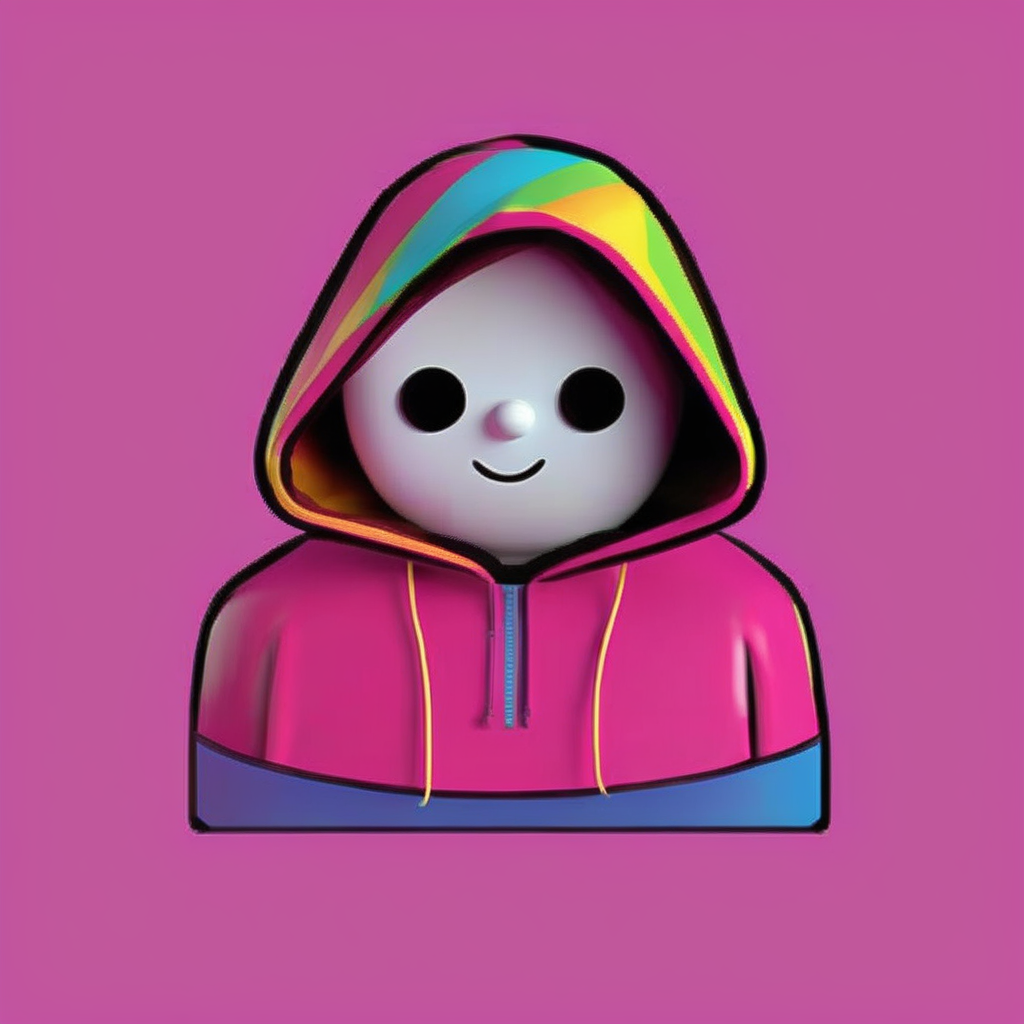

In [4]:
prompt = "toy_face of a hacker with a hoodie"

lora_scale= 0.9
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5, cross_attention_kwargs={"scale": lora_scale}).images[0]
# Display the image
image

## Loading the second adapter: Pixel art adapter

Next, we will load the adapter from `nerijs/pixel-art-xl` that has been fine-tuned to generate pixel art images.

Let's call that adapter `pixel`!

The pipeline will automatically set the first loaded adapter as the active adapter. We will cover in the next sections how to switch between adapters.

In [5]:
pipe.load_lora_weights("nerijs/pixel-art-xl", weight_name="pixel-art-xl.safetensors", adapter_name="pixel")

As mentioned above, you need to manually set the active adapter to 'pixel' in order to activate it. For that, simply call the `set_adapters` API with the correct adapter name.

In [7]:
pipe.set_adapters("pixel")

Let's now generate the image with the second adapter and check the result

  0%|          | 0/30 [00:00<?, ?it/s]

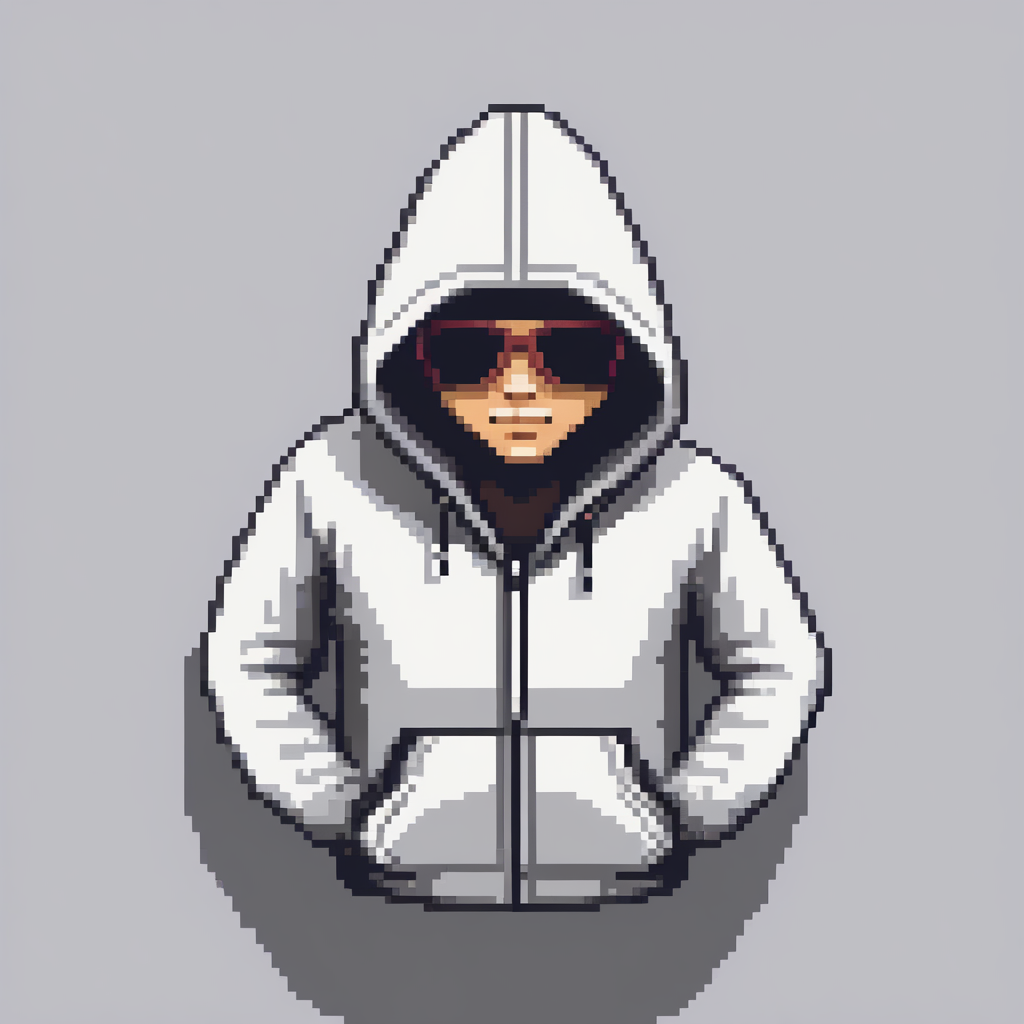

In [8]:
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5, cross_attention_kwargs={"scale": lora_scale}).images[0]
# Display the image
image

## Combining multiple adapter!

Let's see now how to mix both adapters.. What happens if I want to generate an image that has both the style of `toy` and `pixel` adapters?

For that simply pass a list to `set_adapters` - you can also pass an optional argument - `unet_weights` to that method to assign weightage to each adapter.

In [9]:
pipe.set_adapters(["pixel","toy"], unet_weights=[0.5,1.0])

Now that we have set these two adapters, let's generate an image by combining the adapters!

  0%|          | 0/30 [00:00<?, ?it/s]

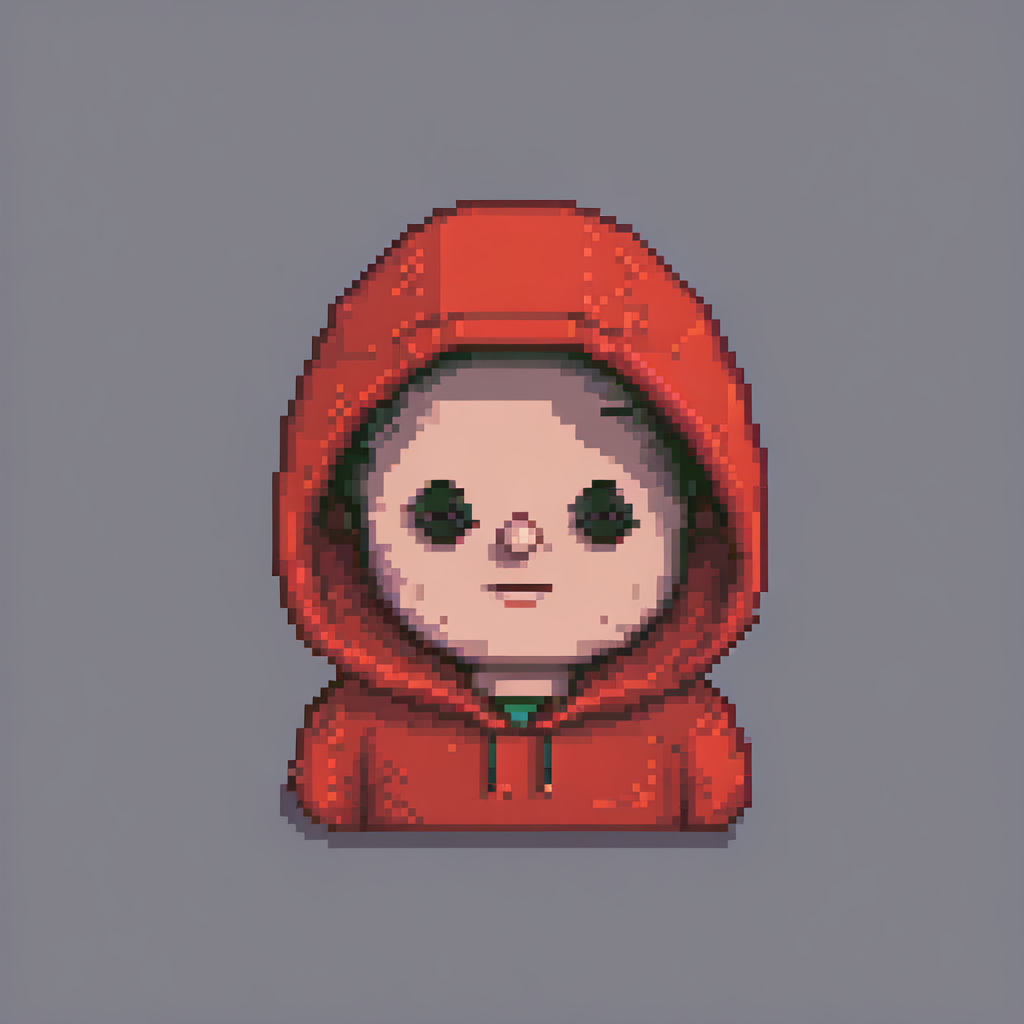

In [10]:
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5, cross_attention_kwargs={"scale": 1.0}).images[0]
image

Impressive! As you can see, the model was able to generate an image that mixes the characteritics of both adapters.

## Disabling all LoRAs

If you want to switch to the base model, you can disable all LoRAs with the `disable_lora()` API

In [11]:
pipe.disable_lora()

In [14]:
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5, cross_attention_kwargs={"scale": 1.0}).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

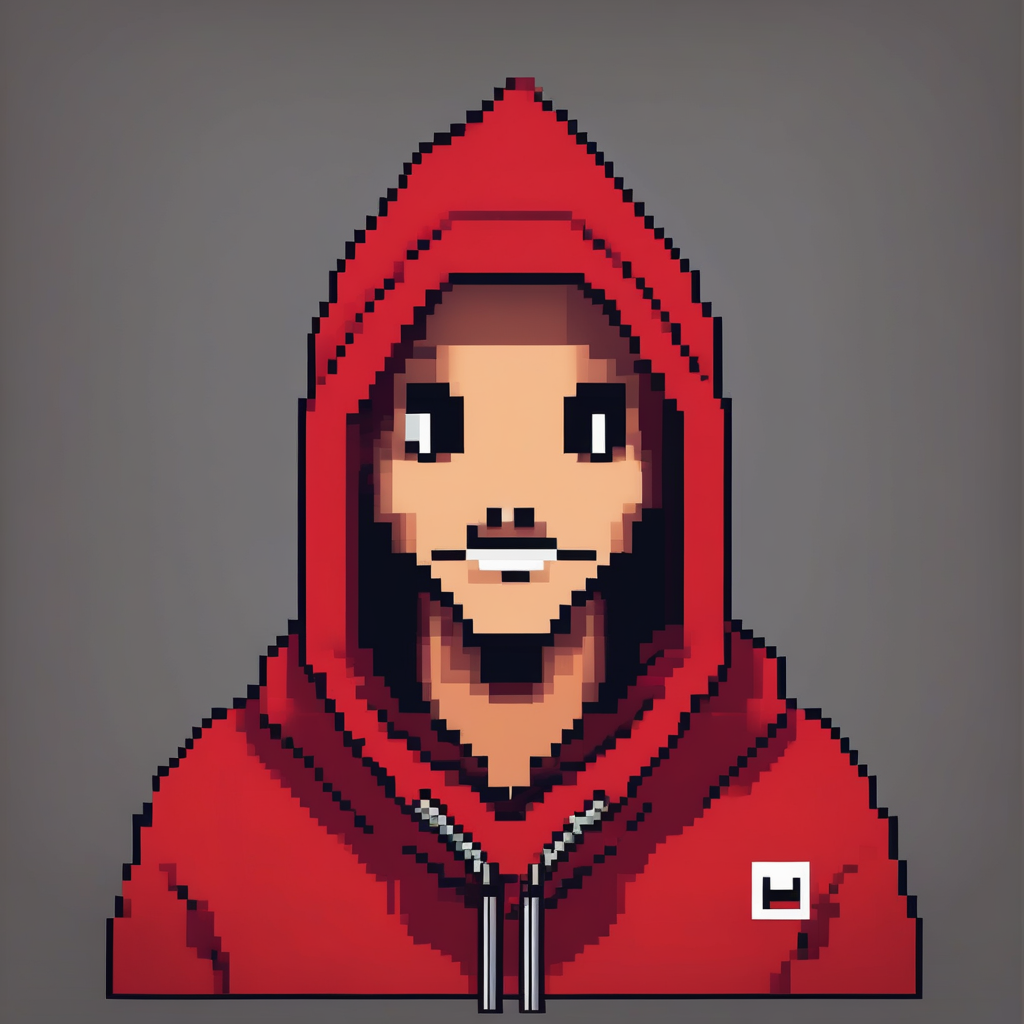

In [15]:
image

Note that you can scale this approach to N adapters, you can load as many adapters as you want and apply the same approach as presented here.